# PHARO Analysis
Reproducing results form Martinache+ 2020 with P3K/PHARO data.

## Pupil mask model
First, we model the pupil mask

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xara
from matplotlib import rcParams, rcParamsDefault
from matplotlib.colors import LogNorm, PowerNorm
from xaosim.pupil import PHARO

rcParams.update(rcParamsDefault)
rcParams["font.size"] = 18
rcParams["xtick.top"] = True
rcParams["xtick.direction"] = "in"
rcParams["ytick.right"] = True
rcParams["ytick.direction"] = "in"

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
rcParams["figure.autolayout"] = True
rcParams["savefig.bbox"] = "tight"

plt.style.use("tableau-colorblind10")

In [2]:
binary_model = True
PSZ = 4978 * 2  # size of array
pdiam = 4.978  # diam of telescope
mstep = 0.160  # step size in meters

pmask = PHARO(PSZ, PSZ / 2, mask="std")
pmask2 = PHARO(PSZ, PSZ / 2, mask="std", ang=-2)  # rotated
ppscale = pdiam / PSZ

if binary_model:
    mtype = "bina"
    p3k_model = xara.core.create_discrete_model(
        pmask, ppscale, mstep, binary=True, tmin=0.4
    )
else:
    mtype = "grey"
    p3k_model = xara.core.create_discrete_model(
        pmask, ppscale, mstep, binary=False, tmin=0.05
    )
    p3k_model[:, 2] = np.round(p3k_model[:, 2], 2)

In [3]:
# Rotate model by 2 deg
th0 = -2.0 * np.pi / 180.0
rmat = np.array(
    [[np.cos(th0), -np.sin(th0)],
     [np.sin(th0), np.cos(th0)]]
)
p3k_model[:, :2] = p3k_model[:, :2].dot(rmat)

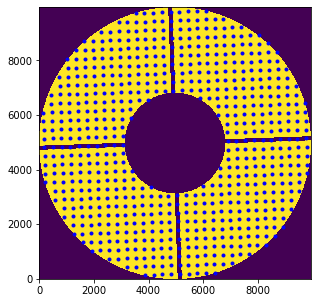

In [4]:
f0 = plt.figure(0)
f0.clf()
ax = f0.add_subplot(111)
ax.imshow(pmask2)
ax.plot(
    PSZ / 2 + p3k_model[:, 0] / ppscale,
    PSZ / 2 + p3k_model[:, 1] / ppscale,
    "b."
)
f0.set_size_inches(5, 5, forward=True)
plt.show()

Now, generate the Kernel Phase Object

Attempting to build KPI from array
1504 distinct baselines were identified
1318 baselines were preserved after filtering
first 10 singular values for this array:
[320.86869 320.30934 171.06726 170.86091 140.71755 140.50295  86.24589
  85.91205  44.56702  44.41059]
<xara.kpi.KPI object at 0x7f1cfc0bb790> KPI data structure
----------------------------------------
-> 668 sub-apertures
-> 1318 distinct baselines
-> 984 Ker-phases ( 74.7 % target phase)
-> 334 Eig-phases ( 50.1 % wavefront phase)
----------------------------------------

KPI data successfully created
No KPO data included


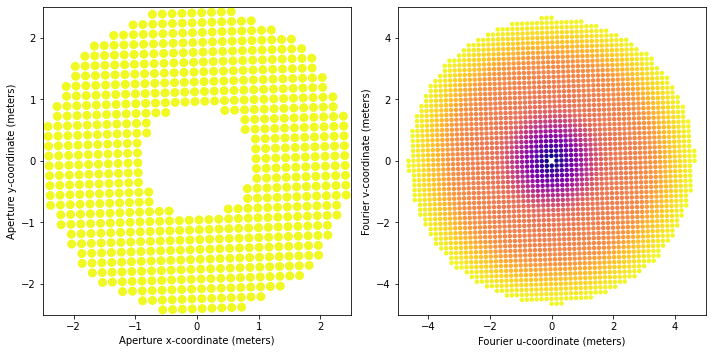

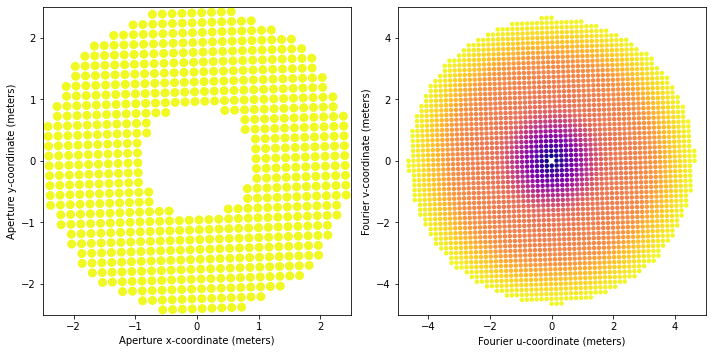

In [5]:
kpo_0 = xara.KPO(array=p3k_model, bmax=4.646)

kpo_0.kpi.plot_pupil_and_uv(xymax=2.5, cmap=plt.cm.plasma_r, ssize=9, figsize=(10,5), marker='o')
plt.show()

## Data analysis
### Extraction

In [6]:
from astropy.io import fits

tgt_cube = fits.getdata("/home/vandal/Documents/jwst/data/pharo_kernel/PHARO/tgt_cube.fits")
ca2_cube = fits.getdata("/home/vandal/Documents/jwst/data/pharo_kernel/PHARO/ca2_cube.fits")

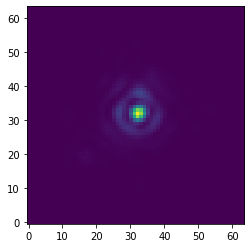

In [7]:
plt.imshow(tgt_cube[0], norm=PowerNorm(0.5, vmin=0), origin="lower")
plt.show()

In [8]:
pscale = 25.0  # plaet scale in mas/pixel
wl = 2.145e-6  # central wl in meters
ISZ = tgt_cube.shape[1]  # image size
kpo1 = xara.KPO(fname="/home/vandal/Documents/jwst/data/pharo_kernel/PHARO/p3k_med_grey_model.fits")
kpo2 = kpo1.copy()

target_name = "alpha Ophiuchi"
calib_name = "epsilon Herculis"
kpo1.extract_KPD_single_cube(
    tgt_cube, pscale, wl, target=target_name, recenter=True
)
kpo2.extract_KPD_single_cube(
    ca2_cube, pscale, wl, target=calib_name, recenter=True
)

Attempting to load file data/PHARO/p3k_med_grey_model.fits
KPI data successfully loaded
The file contains 0 data-sets
CWAVEL was not set
No covariance data available

Cube slice   1 / 100
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 100 / 100


Cube slice   1 / 100
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 100 / 100



### Calibration of the kernel phase
Average KP on frames and calibrate. Also add error to get chi2=1.0

In [9]:
data1 = np.array(kpo1.KPDT)[0]
data2 = np.array(kpo2.KPDT)[0]

In [11]:
mydata1 = np.median(data1, axis=0)
myerr1 = np.sqrt(
    np.var(data1, axis=0) / (kpo1.KPDT[0].shape[0] - 1)
)
# myerr = np.sqrt(myerr ** 2 + 1.2 ** 2)

# # %%
# plt.errorbar(np.arange(len(mydata1)), mydata1, yerr=np.zeros_like(mydata1), fmt=".")
# plt.show()
#

In [ ]:
mydata2 = np.median(data2, axis=0)
myerr2 = np.sqrt(
    np.var(data2, axis=0) / (kpo2.KPDT[0].shape[0] - 1)
)
# myerr = np.sqrt(myerr ** 2 + 1.2 ** 2)

In [ ]:
mydata = np.median(data1, axis=0) - np.median(data2, axis=0)
myerr = np.sqrt(
    np.var(data1, axis=0) / (kpo1.KPDT[0].shape[0] - 1)
    + np.var(data2, axis=0) / (kpo2.KPDT[0].shape[0] - 1)
)
myerr = np.sqrt(myerr ** 2 + 1.2 ** 2)

In [ ]:
offset = np.std(mydata1) * 5
plt.plot(mydata1, label=target_name)
plt.plot(mydata2, "--", label=calib_name)
plt.plot(mydata - offset, label=f"Calibrated {target_name}")
plt.legend()
plt.show()

In [ ]:
gsize = 100
gstep = 10  # in mas
xx, yy = np.meshgrid(np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

mmap1 = kpo1.kpd_binary_match_map(gsize, gstep, mydata1, norm=True)
x0, y0 = np.argmax(mmap1) % gsize, np.argmax(mmap1) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))

In [ ]:
f1 = plt.figure(figsize=(5,5))
ax1 = f1.add_subplot(111)
ax1.imshow(mmap1, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("Raw signal colinearity map")
ax1.grid()
f1.set_tight_layout(True)
f1.canvas.draw()
plt.show()

In [ ]:
mmap2 = kpo2.kpd_binary_match_map(gsize, gstep, mydata2, norm=True)
x0, y0 = np.argmax(mmap2) % gsize, np.argmax(mmap2) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))

In [ ]:
f1 = plt.figure(figsize=(5,5))
ax1 = f1.add_subplot(111)
ax1.imshow(mmap2, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("Calibrator signal colinearity map")
ax1.grid()
f1.set_tight_layout(True)
f1.canvas.draw()
plt.show()



### Colinearity maps
KP signature of binary is directly proportional to contrast.
Look at RA/DEC space around object where calibrated KP best mimics companion:
finite number of pts on grid, compote theoretical signal of companion and compute
dot productself.

Bc KP sensitive to asymmetric features, colin. maps are anti-symmetric.

In [ ]:
gsize = 100
gstep = 10  # in mas
xx, yy = np.meshgrid(np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

In [ ]:
mmap = kpo1.kpd_binary_match_map(gsize, gstep, mydata, norm=True)
x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))

f1 = plt.figure(figsize=(5,5))
ax1 = f1.add_subplot(111)
ax1.imshow(mmap, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("Calibrated signal colinearity map")
ax1.grid()
f1.set_tight_layout(True)
f1.canvas.draw()
plt.show()

### Chi^2 minimization
Colinearity map solution makes a good first guess for further analysis.

In [ ]:
p0 = [dist[y0, x0], azim[y0, x0], mmap.max()]

mfit = kpo1.binary_model_fit(p0, calib=kpo2)
p1 = mfit[0]  # Best fit parameter [sep, pa, cr]

cvis_b = xara.core.cvis_binary(
    kpo1.kpi.UVC[:,0], kpo1.kpi.UVC[:,1], wl, p1
)
ker_theo = kpo1.kpi.KPM.dot(np.angle(cvis_b))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(ker_theo, mydata, yerr=myerr, fmt="none", ecolor='c')
ax.plot(ker_theo, mydata, 'b.')
mmax = np.round(np.abs(mydata).max())
ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
ax.set_ylabel("data kernel-phase")
ax.set_xlabel("model kernel-phase")
ax.set_title('kernel-phase correlation diagram')
ax.axis("equal")
ax.axis([-11, 11, -11, 11])
fig.set_tight_layout(True)
plt.show()

if myerr is not None:
        chi2 = np.sum(((mydata - ker_theo)/myerr)**2) / kpo1.kpi.nbkp
else:
        chi2 = np.sum(((mydata - ker_theo))**2) / kpo1.kpi.nbkp